# LLM

### Openai

In [100]:
import os
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
load_dotenv()

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

llm_openai = ChatOpenAI(
                api_key=OPENAI_API_KEY, 
                model='gpt-3.5-turbo', 
                temperature=0.7)
llm_openai

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x000002F254061070>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000002F257290D30>, root_client=<openai.OpenAI object at 0x000002F25731FEE0>, root_async_client=<openai.AsyncOpenAI object at 0x000002F25763E040>, temperature=0.7, model_kwargs={}, openai_api_key=SecretStr('**********'))

In [16]:
# verify
llm_openai.invoke('what is the capital of Japan?')

AIMessage(content='The capital of Japan is Tokyo.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 7, 'prompt_tokens': 14, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BvdqlmSvnf4Ttj0uWYkGovDFwiss3', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--1ce95d4f-b4a2-441e-8cec-7df42c63c22a-0', usage_metadata={'input_tokens': 14, 'output_tokens': 7, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [17]:
# verify
from langchain_core.messages import HumanMessage, SystemMessage

sample_messages = [
    SystemMessage(content="You are a pet veterinarian."),
    HumanMessage(content="Explain cat hissing sound")
]
sample_answer = llm_openai.invoke(sample_messages)
sample_answer.content

"When a cat hisses, it is a warning sign that they are feeling threatened, scared, or agitated. The hissing sound is a way for them to communicate that they are feeling uncomfortable and that they may be ready to defend themselves if necessary. Cats may hiss when they encounter unfamiliar animals, people, or situations that make them feel uneasy.\n\nIt's important to pay attention to your cat's body language when they are hissing, as it can give you clues about what is causing their distress. For example, if their ears are flattened back, their fur is standing on end, or they are crouched low to the ground, they are likely feeling very frightened or defensive.\n\nIf your cat is hissing, it is best to give them space and allow them to calm down on their own. Avoid approaching them or trying to comfort them until they have had a chance to relax. If the hissing continues or if your cat's behavior changes significantly, it may be a good idea to consult with a veterinarian to rule out any u

### Deepinfra gemma

In [90]:
from langchain_community.chat_models import ChatDeepInfra

llm_deepinfra = ChatDeepInfra(
                    model="google/gemma-3-4b-it",
                    temperature=0.7,
                    max_tokens=512,
                )
llm_deepinfra

ChatDeepInfra(model_name='google/gemma-3-4b-it', deepinfra_api_token='Aqaz1fN9vn5oWeqdAp6BZg04vTf2Iv8V', temperature=0.7, model_kwargs={}, max_tokens=512)

In [42]:
# Verify
sample_answer = llm_deepinfra.invoke("what is the capital of Japan?")
sample_answer.content

'The capital of Japan is **Tokyo**. \n\nIt’s a massive, vibrant city and the center of Japanese government, culture, and economy. 😊'

In [82]:
# Verify 2
sample_messages = [
    SystemMessage(content="You are a travel expert."),
    HumanMessage(content="what is the capital of Japan?")
]
sample_answer = llm_deepinfra.invoke(sample_messages)
sample_answer.content

'Ah, a classic question! The capital of Japan is **Tokyo** (officially Tokyo-to). \n\nIt’s a truly fascinating city – a massive blend of ancient tradition and cutting-edge modernity. \n\nWould you like to know anything more about Tokyo, like:\n\n*   Its history?\n*   Popular attractions (like the Shibuya crossing or the Imperial Palace)?\n*   What it’s like to experience it?'

# Graph Builder

In [6]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [8]:
class State(TypedDict): #inherit Typedict 
   # `add_messages` is a reducer: it appends new messages to the existing list
    messages: Annotated[list, add_messages] 

# example:
# {
#     "messages": [
#         {"role": "user",    "content": "hi"},
#         {"role": "assistant", "content": "Hello!"},
#         ...
#     ]
# }

In [9]:
# chatbot node
def chatbot(state: State) -> State: 
    reply = llm_deepinfra.invoke(state["messages"])
    return {"messages": reply}         

In [10]:
graph_builder = StateGraph(State)

# node
graph_builder.add_node('llm_chatbot',chatbot)
# add start edge
graph_builder.add_edge(START, 'llm_chatbot')
# add end edge
graph_builder.add_edge('llm_chatbot', END)


# compile the graph
graph = graph_builder.compile()

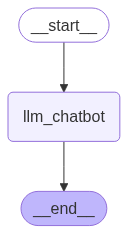

In [11]:
# Visualize
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
response = graph.invoke({"messages": 'hi'})
response

{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='4311bd24-31d2-44ce-a143-6070ac5032f4'),
  AIMessage(content='Hi there! How’s your day going so far? Is there anything you’d like to chat about, or were you just saying hello? 😊', additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 10, 'total_tokens': 42, 'completion_tokens': 32, 'estimated_cost': 1.48e-06}, 'model': 'google/gemma-3-4b-it', 'finish_reason': 'stop'}, id='run--bf072d33-2c6c-4916-b6b7-14e6582a2ca5-0')]}

In [13]:
# response['messages']
response['messages'][-1].content

'Hi there! How’s your day going so far? Is there anything you’d like to chat about, or were you just saying hello? 😊'

# Tools
Do not rely on a prompt instruction alone.
Register a real search tool and let the LLM invoke it via function-calling; that is the robust, production-ready way to give any LLM live web access today 

In [ ]:
from langchain_tavily import TavilySearch

TAVILY_API_KEY=os.getenv('TAVILY_API_KEY')

In [138]:
# Websearch tool
tool_websearch=TavilySearch(max_results=2)

In [136]:
# Custom tool
def Room_AC_Horsepower_Computation(length:int,
                                   width:int) -> float:
    '''Compute the required AC horsepower for a room.

    Multiply length × width to get square metres, then divide by 9
    to estimate horsepower (1 HP ≈ 10 m²).

    Args:
        length (int): Room length in metres.
        width (int): Room width in metres.

    Returns:
        float: Recommended horsepower (HP).
    '''

    sqm = length * width
    hp = sqm/10
    return hp

# test
Room_AC_Horsepower_Computation(3, 4)

1.2

In [139]:
tools = [tool_websearch, Room_AC_Horsepower_Computation]

# Bind the tools to llm
# llm_deepinfra_tools = llm_deepinfra.bind_tools(tools)
llm_openai_tools = llm_openai.bind_tools(tools)



In [102]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

class State(TypedDict): 
    messages: Annotated[list, add_messages]
    
# Node difinition
def chatbot_with_tools(state: State) -> State: 
            # reply = llm_deepinfra_tools.invoke(state["messages"])
            reply = llm_openai_tools.invoke(state["messages"])
            return {"messages": reply}   

In [104]:
builder = StateGraph(State)

builder.add_node('chatbot_with_tools', chatbot_with_tools)
builder.add_node('tools', ToolNode(tools))

builder.add_edge(START, 'chatbot_with_tools')

builder.add_conditional_edges('chatbot_with_tools', tools_condition)
    # if latest messages is atool call route to tools
    # if not a tool call route to end

# from tools return to LLM to format the answer (dont go directly to end)
builder.add_edge('tools', 'chatbot_with_tools')

graph = builder.compile()

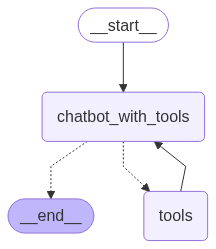

In [105]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [106]:
web_question = 'what is the weather in Manila Philippines right now'
hp_question = "what is the horse power needed in a room with lenght is 3 meters and width is 5 meters? "

In [70]:
# response = graph.invoke({"messages": web_question})
# response

In [71]:
# response['messages'][-1].content

In [107]:
response = graph.invoke({"messages": web_question})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is the weather in Manila Philippines right now
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_iKs9DgPkZTzoF4hShmumpp26)
 Call ID: call_iKs9DgPkZTzoF4hShmumpp26
  Args:
    query: current weather in Manila Philippines
    search_depth: basic
================================= Tool Message =================================
Name: tavily_search

{"query": "current weather in Manila Philippines", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Weather in Manila, Philippines", "url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Manila', 'region': 'Manila', 'country': 'Philippines', 'lat': 14.6042, 'lon': 120.9822, 'tz_id': 'Asia/Manila', 'localtime_epoch': 1753082560, 'localtime': '2025-07-21 15:22'}, 'current': {'last_updated_epoch': 1753082100, 'last_updated': '2025-07-21 15:15', 'tem

In [159]:
# response = graph.invoke({"messages": hp_question})

# for m in response['messages']:
#     m.pretty_print()

# Adding Memory

In [140]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

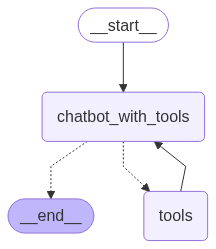

In [141]:
memory = MemorySaver()

class State(TypedDict): 
    messages: Annotated[list, add_messages]
    

def chatbot_with_tools(state: State) -> State: 
            # reply = llm_deepinfra_tools.invoke(state["messages"])
            reply = llm_openai_tools.invoke(state["messages"])
            return {"messages": reply}   

builder = StateGraph(State)

builder.add_node('chatbot_with_tools', chatbot_with_tools)
builder.add_node('tools', ToolNode(tools))

builder.add_edge(START, 'chatbot_with_tools')

builder.add_conditional_edges('chatbot_with_tools', tools_condition)
    # if latest messages is atool call route to tools
    # if not a tool call route to end

# from tools return to LLM to format the answer (dont go directly to end)
builder.add_edge('tools', 'chatbot_with_tools')

graph = builder.compile(checkpointer=memory)

# view
display(Image(graph.get_graph().draw_mermaid_png()))

In [142]:
config = {'configurable':{'thread_id':'2'}}
config

{'configurable': {'thread_id': '2'}}

In [143]:
response = graph.invoke({'messages':'what is my name again?'}, config=config)
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is my name again?
================================== Ai Message ==================================

I'm sorry, but I don't have access to your personal information, including your name. If there's anything else you'd like to know or discuss, feel free to ask!


In [144]:
# see the last message
response['messages'][-1].content

"I'm sorry, but I don't have access to your personal information, including your name. If there's anything else you'd like to know or discuss, feel free to ask!"

# Stream

In [145]:
config = {'configurable':{'thread_id':'99'}}

In [149]:
a = 'hi im kai'
b = 'its raining here'
c = 'whats my name again?'


In [ ]:
for chunk in graph.stream({'messages':c}, config=config, stream_mode='updates'):
    print(chunk)

{'chatbot_with_tools': {'messages': AIMessage(content='Your name is Kai. If you have any other questions or need help with something, feel free to let me know!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 1473, 'total_tokens': 1498, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BvgMSTZgfc62XrQlar8AEbYLN4Ayu', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--762ab196-300a-4a49-b18c-e91c590cc677-0', usage_metadata={'input_tokens': 1473, 'output_tokens': 25, 'total_tokens': 1498, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}}


In [155]:
config = {'configurable':{'thread_id':'101'}}
for chunk in graph.stream({'messages':c}, config=config, stream_mode='values'):
    print(chunk)

{'messages': [HumanMessage(content='hi im kai', additional_kwargs={}, response_metadata={}, id='e69ae8bd-f403-466d-b0db-3103dce8ab3b'), AIMessage(content='Hello Kai! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 1413, 'total_tokens': 1424, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BvgNMJr7KQdDR85qmjGd7TPA5YGsd', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--7062a7a5-eaef-4f6a-b5da-5560d60ebecd-0', usage_metadata={'input_tokens': 1413, 'output_tokens': 11, 'total_tokens': 1424, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='its rainin

In [158]:
config = {'configurable':{'thread_id':'69'}}
for chunk in graph.stream({'messages':c}, config=config, stream_mode='messages'):
    print(chunk)

(AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run--0504fbe6-e15d-4a8b-8159-12eb1e89958f'), {'thread_id': '69', 'langgraph_step': 7, 'langgraph_node': 'chatbot_with_tools', 'langgraph_triggers': ('branch:to:chatbot_with_tools',), 'langgraph_path': ('__pregel_pull', 'chatbot_with_tools'), 'langgraph_checkpoint_ns': 'chatbot_with_tools:6e1fd6bc-cac9-b22e-5ed9-340945e47867', 'checkpoint_ns': 'chatbot_with_tools:6e1fd6bc-cac9-b22e-5ed9-340945e47867', 'ls_provider': 'openai', 'ls_model_name': 'gpt-3.5-turbo', 'ls_model_type': 'chat', 'ls_temperature': 0.7})
(AIMessageChunk(content='Your', additional_kwargs={}, response_metadata={}, id='run--0504fbe6-e15d-4a8b-8159-12eb1e89958f'), {'thread_id': '69', 'langgraph_step': 7, 'langgraph_node': 'chatbot_with_tools', 'langgraph_triggers': ('branch:to:chatbot_with_tools',), 'langgraph_path': ('__pregel_pull', 'chatbot_with_tools'), 'langgraph_checkpoint_ns': 'chatbot_with_tools:6e1fd6bc-cac9-b22e-5ed9-340945e47867', 'che

# Human in the loop

In [ ]:
import os
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.types import Command, interrupt
# from langchain_tavily import TavilySearch
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

from dotenv import load_dotenv
load_dotenv()

True

In [169]:
# .env keys
TAVILY_API_KEY=os.getenv('TAVILY_API_KEY')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

# llm
llm_openai = ChatOpenAI(
                api_key=OPENAI_API_KEY, 
                model='gpt-3.5-turbo', 
                temperature=0.7)

In [229]:
# Tools

# websearch
websearch = TavilySearchResults(max_results=2)


@tool
def Room_AC_Horsepower_Computation(length:int,
                                   width:int) -> float:
    '''Compute the required AC horsepower for a room.

    Multiply length × width to get square metres, then divide by 9
    to estimate horsepower (1 HP ≈ 10 m²).

    Args:
        length (int): Room length in metres.
        width (int): Room width in metres.

    Returns:
        float: Recommended horsepower (HP).
    '''

    sqm = length * width
    hp = sqm/10
    return hp

# human intervention
from langchain_core.tools import tool

@tool
def human_assistance(query: str) -> str:
    """
    Im the supervisor.
    .
    """
    human_response = interrupt({'query': query})
    return human_response['data']

tools = [websearch, Room_AC_Horsepower_Computation, human_assistance]
llm_openai_tools = llm_openai.bind_tools(tools)

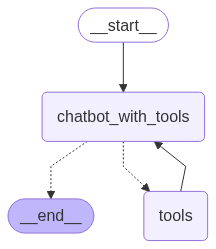

In [230]:
memory = MemorySaver()

class State(TypedDict): 
    messages: Annotated[list, add_messages]
    

def chatbot_with_tools(state: State) -> State: 
            # reply = llm_deepinfra_tools.invoke(state["messages"])
            reply = llm_openai_tools.invoke(state["messages"])
            return {"messages": reply}   

builder = StateGraph(State)
builder.add_edge(START, 'chatbot_with_tools')
builder.add_node('chatbot_with_tools', chatbot_with_tools)

tool_node = ToolNode(tools = tools)
builder.add_node('tools', tool_node)

builder.add_conditional_edges('chatbot_with_tools', tools_condition)
    # if latest messages is atool call route to tools
    # if not a tool call route to end

# from tools return to LLM to format the answer (dont go directly to end)
builder.add_edge('tools', 'chatbot_with_tools')

graph = builder.compile(checkpointer=memory)

# view
display(Image(graph.get_graph().draw_mermaid_png()))

In [231]:
user_input = 'how many aircon horse power i need my room size is 3 by 4? i need your supervisor your answer?'
config = {'configurable': {'thread_id': "101"}}

events = graph.stream(
    {"messages": user_input},
    config=config,
    stream_mode="values"
)

for event in events:
    if 'messages' in event:
        event['messages'][-1].pretty_print()

================================ Human Message =================================

how many aircon horse power i need my room size is 3 by 4? i need your supervisor your answer?
================================== Ai Message ==================================
Tool Calls:
  Room_AC_Horsepower_Computation (call_HQ2cnQLaiWcBMNSR887OS6Ki)
 Call ID: call_HQ2cnQLaiWcBMNSR887OS6Ki
  Args:
    length: 3
    width: 4
  human_assistance (call_cCnFx8iF7MfKuwpiJMCRH407)
 Call ID: call_cCnFx8iF7MfKuwpiJMCRH407
  Args:
    query: I need your supervisor


In [232]:
human_response = ('Im the supervisor I will handle this')
human_command = Command(resume={'data': human_response})

events = graph.stream(
    human_command,
    config=config,
    stream_mode="values"
)

for event in events:
    if 'messages' in event:
        event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Room_AC_Horsepower_Computation (call_HQ2cnQLaiWcBMNSR887OS6Ki)
 Call ID: call_HQ2cnQLaiWcBMNSR887OS6Ki
  Args:
    length: 3
    width: 4
  human_assistance (call_cCnFx8iF7MfKuwpiJMCRH407)
 Call ID: call_cCnFx8iF7MfKuwpiJMCRH407
  Args:
    query: I need your supervisor
================================= Tool Message =================================
Name: human_assistance

Im the supervisor I will handle this
================================== Ai Message ==================================

Based on the room size of 3 by 4 meters, you would need approximately 1.2 horsepower for your air conditioner. Additionally, I am the supervisor and will handle any further assistance or questions you may have.


Command(resume={'data': 'yes'})